# Great Energy Predictor - Features

<a id='content3'></a>
## Content

1. [Data Description](#description3)
2. [Imports](#imports3)
3. [Data Preparation](#prep)
4. [Feature Elimination](#elim)
5. [Feature Selection](#seln)

<a id='description3'></a>
## 1. Data Description
[Back to top](#content3)

The data is a 2016 collection of energy meter readings (from over 1,000 buildings in 16 sites around the world) and weather measurements (from the nearest weather station for each site). It consists of 3 relational files of tabular data with the following features:
##### 1. train.csv - contains energy consumption measurements from 4 types of building meters in 2016
    - building_id - identifies the building
        - There are 1449 buildings in 16 sites around the world in this dataset
    - meter - meter type (not all buildings have all meter types)
        - 0 - electricity
        - 1 - chilldwater
        - 2 - steam
        - 3 - hotwater
    - timestamp - date and time of the meter reading
        - This dataset contains measurements over a span of an entire year
    - meter_reading - Energy consumption, (this is the target variable)
        - Electric meter readings are in kWh
            - Electric meter readings for site 0 are in kBTU
        - Chilled water meter readings are in tons
            - Chilled water meter readings for site 0 are in kBTU
        - Steam meter readings are in lbs
        - Hot water meter readings are in mmBTU
##### 2. weather_train.csv - contains weather measurements in 2016 from the weather station that is closest to the site
    - site_id - identifies the site where the building is
    - timestamp - date and time of the weather measurements
    - air_temperature - air temperature, in degrees Celsius
    - cloud_coverage - portion of the sky covered by clouds, in oktas
    - dew_temperature - temperature at which dew forms, in degrees Celsius
    - precip_depth_1_hr - measure of rainfail in 1 hour, in millimeters (mm)
    - sea_level_pressure - atmospheric pressure at sea level, in millibar (mbar) or hectopascals (hPa)
    - wind_direction - compass direction of the wind (0 - 360)
    - wind_speed - wind speed, in meters per second (m/s)
##### 3. building_metadata.csv - contains details about the buildings in the dataset
    - site_id - identifies the site where the building is
    - building_id - identifies the building
    - primary_use - what the building is used for (based on EnergyStar's property types)
    - square_feet - gross floor area of the building, in square feet (ft^2)
    - year_built - year the building was opened
    - floor_count - number of floors the building has
    
This data was retrieved from a public Kaggle competition hosted by ASHRAE.
##### Source: https://www.kaggle.com/c/ashrae-energy-prediction/data

<a id='imports3'></a>
## 2. Imports
[Back to top](#content3)

##### Import libraries

In [13]:
%matplotlib inline

import src.utils as udf

import gc
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# import ray.dataframe as pd

In [14]:
# Default plot settings
sns.set(rc={'figure.figsize': (16, 6), 
            'font.size': 12})

##### Import data

In [15]:
data_path = '../data/output/'

In [16]:
df = pd.read_csv(f'{data_path}eda_train.csv', parse_dates=['timestamp']).iloc[:, 1:]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20137746 entries, 0 to 20137745
Data columns (total 20 columns):
site_id               int64
building_id           int64
use_encoded           int64
primary_use           object
year_built            int64
floor_count           int64
square_feet           int64
timestamp             datetime64[ns]
meter                 int64
type                  object
meter_reading         float64
air_temperature       float64
dew_temperature       float64
sea_level_pressure    float64
cloud_coverage        float64
precip_depth_1_hr     float64
wind_direction        float64
wind_direction_x      float64
wind_direction_y      float64
wind_speed            float64
dtypes: datetime64[ns](1), float64(10), int64(7), object(2)
memory usage: 3.0+ GB


In [17]:
df.cloud_coverage = df.cloud_coverage.astype(int)
df.wind_direction = df.wind_direction.astype(int)

In [18]:
df = udf.reduce_mem(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20137746 entries, 0 to 20137745
Data columns (total 20 columns):
site_id               uint8
building_id           uint16
use_encoded           uint8
primary_use           category
year_built            uint16
floor_count           uint8
square_feet           uint32
timestamp             datetime64[ns]
meter                 uint8
type                  category
meter_reading         float32
air_temperature       float32
dew_temperature       float32
sea_level_pressure    float32
cloud_coverage        uint8
precip_depth_1_hr     float32
wind_direction        uint16
wind_direction_x      float32
wind_direction_y      float32
wind_speed            float32
dtypes: category(2), datetime64[ns](1), float32(8), uint16(3), uint32(1), uint8(5)
memory usage: 1.1 GB


<a id='prep'></a>
## 3. Data Preparation
[Back to top](#content3)

The `timestamp` column cannot be used in modeling so it will be removed and represented by other numeric columns. The 2 categorical columns `primary_use` and `type` also cannot be used in modeling so they will also be removed. These 2 columns have already been encoded into integers in separate columns. But since these categorical variables have no ordering to their values, it makes more sense to one-hot encode them.

##### Prepare the columns for feature selection

In [19]:
# Extract the datetime components of timestamps into new columns
df = udf.extract_from_dt(df, ['dayofyear', 'month', 'day', 'dayofweek', 'hour'])
df.tail()

site_id  building_id  use_encoded                    primary_use  \
20137741       15         1444            1  Entertainment/public assembly   
20137742       15         1445            0                      Education   
20137743       15         1446            1  Entertainment/public assembly   
20137744       15         1447            4            Lodging/residential   
20137745       15         1448            6                         Office   

          year_built  floor_count  square_feet           timestamp  meter  \
20137741        1914            1        19619 2016-12-31 23:00:00      0   
20137742        1964            1         4298 2016-12-31 23:00:00      0   
20137743        1997            1        11265 2016-12-31 23:00:00      0   
20137744        2001            1        29775 2016-12-31 23:00:00      0   
20137745        2001            3        92271 2016-12-31 23:00:00      0   

                 type  ...  precip_depth_1_hr  wind_direction  \
20137741  electricity  ...               0.01             180   
20137742  electricity  ...               0.01             180   
20137743  electricity  ...               0.01             180   
20137744  electricity  ...               0.01             180   
20137745  electricity  ...               0.01             180   

          wind_direction_x  wind_direction_y  wind_speed  dayofyear  month  \
20137741              -1.0      1.224647e-16         8.8        366     12   
20137742              -1.0      1.224647e-16         8.8        366     12   
20137743              -1.0      1.224647e-16         8.8        366     12   
20137744              -1.0      1.224647e-16         8.8        366     12   
20137745              -1.0      1.224647e-16         8.8        366     12   

          day  dayofweek  hour  
20137741   31          5    23  
20137742   31          5    23  
20137743   31          5    23  
20137744   31          5    23  
20137745   31          5    23  

[5 rows x 25 columns]

In [20]:
# One-hot encode primary use
primary_use_ohe = udf.encode_cat(OneHotEncoder(sparse=False), df, 'primary_use')
primary_use_ohe.head()

Education Entertainment/public assembly Food sales and service Healthcare  \
0         1                             0                      0          0   
1         1                             0                      0          0   
2         1                             0                      0          0   
3         1                             0                      0          0   
4         1                             0                      0          0   

  Lodging/residential Manufacturing/industrial Office Other Parking  \
0                   0                        0      0     0       0   
1                   0                        0      0     0       0   
2                   0                        0      0     0       0   
3                   0                        0      0     0       0   
4                   0                        0      0     0       0   

  Public services Religious worship Retail Services Technology/science  \
0               0                 0      0        0                  0   
1               0                 0      0        0                  0   
2               0                 0      0        0                  0   
3               0                 0      0        0                  0   
4               0                 0      0        0                  0   

  Utility Warehouse/storage  
0       0                 0  
1       0                 0  
2       0                 0  
3       0                 0  
4       0                 0

In [21]:
# One-hot encode meter type
meter_type_ohe = udf.encode_cat(OneHotEncoder(sparse=False), df, 'type')
meter_type_ohe.head()

chilledwater electricity hotwater steam
0            0           1        0     0
1            0           1        0     0
2            0           1        0     0
3            0           1        0     0
4            0           1        0     0

In [22]:
# Combine the 2 encoded categories
cats_ohe = pd.concat([meter_type_ohe, primary_use_ohe], axis=1)
cats_ohe.head()

chilledwater electricity hotwater steam Education  \
0            0           1        0     0         1   
1            0           1        0     0         1   
2            0           1        0     0         1   
3            0           1        0     0         1   
4            0           1        0     0         1   

  Entertainment/public assembly Food sales and service Healthcare  \
0                             0                      0          0   
1                             0                      0          0   
2                             0                      0          0   
3                             0                      0          0   
4                             0                      0          0   

  Lodging/residential Manufacturing/industrial Office Other Parking  \
0                   0                        0      0     0       0   
1                   0                        0      0     0       0   
2                   0                        0      0     0       0   
3                   0                        0      0     0       0   
4                   0                        0      0     0       0   

  Public services Religious worship Retail Services Technology/science  \
0               0                 0      0        0                  0   
1               0                 0      0        0                  0   
2               0                 0      0        0                  0   
3               0                 0      0        0                  0   
4               0                 0      0        0                  0   

  Utility Warehouse/storage  
0       0                 0  
1       0                 0  
2       0                 0  
3       0                 0  
4       0                 0

In [23]:
# Drop non-numeric columns and wind_direction
df.drop(['timestamp', 'primary_use', 'type', 'wind_direction'], axis=1, inplace=True)
df = udf.reduce_mem(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20137746 entries, 0 to 20137745
Data columns (total 21 columns):
site_id               uint8
building_id           uint16
use_encoded           uint8
year_built            uint16
floor_count           uint8
square_feet           uint32
meter                 uint8
meter_reading         float32
air_temperature       float32
dew_temperature       float32
sea_level_pressure    float32
cloud_coverage        uint8
precip_depth_1_hr     float32
wind_direction_x      float32
wind_direction_y      float32
wind_speed            float32
dayofyear             uint16
month                 uint8
day                   uint8
dayofweek             uint8
hour                  uint8
dtypes: float32(8), uint16(3), uint32(1), uint8(9)
memory usage: 979.4 MB


##### Separate the target variable and split the dataset into a train and test set

In [24]:
# Variables and target
X = df.drop('meter_reading', axis=1)
y = df.meter_reading

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Train-test split for one-hot encoded categorical variables
cat_train, cat_test, lab_train, lab_test = train_test_split(cats_ohe, y, test_size=0.2, random_state=42)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (16110196, 20)
X_test: (4027550, 20)
y_train: (16110196,)
y_test: (4027550,)


##### Save the full train set before deleting it

In [25]:
# df.to_csv(f'{data_path}train.csv')
# cats_ohe.to_csv(f'{data_path}cats_train.csv')

In [26]:
del df, cats_ohe, primary_use_ohe, meter_type_ohe, lab_train, lab_test
gc.collect()

68

Now the data is ready for feature selection. The one-hot encoded categorical variables are kept separate to avoid cluttering the training data. 

<a id='elim'></a>
## 4. Feature Elimination
[Back to top](#content3)

##### Constant and quasi-constant features

In [27]:
# Main data
const = udf.constant_feats(X_train)
const

variance  constant  quasiconstant
site_id             2.589821e+01     False          False
building_id         1.812953e+05     False          False
use_encoded         1.187137e+01     False          False
year_built          3.844191e+02     False          False
floor_count         1.256733e+01     False          False
square_feet         1.375616e+10     False          False
meter               8.688400e-01     False          False
air_temperature     1.204038e+02     False          False
dew_temperature     1.037428e+02     False          False
sea_level_pressure  5.247845e+01     False          False
cloud_coverage      7.361325e+00     False          False
precip_depth_1_hr   8.025482e+01     False          False
wind_direction_x    4.458890e-01     False          False
wind_direction_y    4.277745e-01     False          False
wind_speed          5.128145e+00     False          False
dayofyear           1.108220e+04     False          False
month               1.181234e+01     False          False
day                 7.779519e+01     False          False
dayofweek           3.988601e+00     False          False
hour                4.792584e+01     False          False

In [28]:
# Categorical data
const_cat = udf.constant_feats(cat_train)
const_cat

variance  constant  quasiconstant
chilledwater                   0.164187     False          False
electricity                    0.240858     False          False
hotwater                       0.058870     False          False
steam                          0.116416     False          False
Education                      0.240752     False          False
Entertainment/public assembly  0.099653     False          False
Food sales and service         0.005625     False           True
Healthcare                     0.019373     False          False
Lodging/residential            0.095270     False          False
Manufacturing/industrial       0.006203     False           True
Office                         0.169957     False          False
Other                          0.011895     False          False
Parking                        0.010521     False          False
Public services                0.075723     False          False
Religious worship              0.001606     False           True
Retail                         0.004703     False           True
Services                       0.004771     False           True
Technology/science             0.003845     False           True
Utility                        0.002781     False           True
Warehouse/storage              0.005508     False           True

In [29]:
# Quasi-constant
qc_cat = [cat[0] for cat in const_cat[const_cat.quasiconstant].index]
qc_cat

['Food sales and service',
 'Manufacturing/industrial',
 'Religious worship',
 'Retail',
 'Services',
 'Technology/science',
 'Utility',
 'Warehouse/storage']

Exactly half of the `primary_use` categories were found to be quasi-constant. As per the variance threshold of 0.01, being quasi-constant means that each of these 8 building types individually make up less than 1% of the total data. For now these will be kept as they are not part of the main data. Aside from this, there are no constant and no other quasi-constant features.

##### Duplicate features

In [30]:
dup = udf.duplicated_feats(X_train)
dup

[]

##### Correlated features

In [31]:
pearson = X_train.corr()
pearson

site_id  building_id  use_encoded  year_built  \
site_id             1.000000     0.980861     0.080181   -0.095307   
building_id         0.980861     1.000000     0.061838   -0.135724   
use_encoded         0.080181     0.061838     1.000000    0.065391   
year_built         -0.095307    -0.135724     0.065391    1.000000   
floor_count         0.017487     0.013682    -0.087734    0.080458   
square_feet         0.087738     0.084269    -0.085659    0.098957   
meter               0.252366     0.220563    -0.081101    0.011316   
air_temperature    -0.306558    -0.313527    -0.044185    0.089907   
dew_temperature    -0.132264    -0.107007    -0.015018    0.033799   
sea_level_pressure  0.051948     0.072042     0.030871   -0.023799   
cloud_coverage     -0.125185    -0.159972     0.143474    0.053754   
precip_depth_1_hr   0.052284     0.055784    -0.022479   -0.014072   
wind_direction_x    0.008490     0.010937     0.008922    0.004110   
wind_direction_y   -0.047054    -0.054085    -0.003020    0.040455   
wind_speed          0.012111     0.004139     0.052509   -0.019765   
dayofyear           0.014951     0.014999    -0.002198   -0.000187   
month               0.015041     0.015079    -0.002221   -0.000175   
day                -0.000436    -0.000314     0.000117    0.000052   
dayofweek          -0.000051    -0.000052    -0.000277   -0.000135   
hour               -0.000097    -0.000056    -0.000179    0.000179   

                    floor_count  square_feet     meter  air_temperature  \
site_id                0.017487     0.087738  0.252366        -0.306558   
building_id            0.013682     0.084269  0.220563        -0.313527   
use_encoded           -0.087734    -0.085659 -0.081101        -0.044185   
year_built             0.080458     0.098957  0.011316         0.089907   
floor_count            1.000000     0.901321  0.099968        -0.024525   
square_feet            0.901321     1.000000  0.131747        -0.015081   
meter                  0.099968     0.131747  1.000000        -0.010970   
air_temperature       -0.024525    -0.015081 -0.010970         1.000000   
dew_temperature       -0.011089    -0.022291 -0.079513         0.751499   
sea_level_pressure    -0.015905    -0.018702 -0.048402        -0.294477   
cloud_coverage        -0.044064    -0.012970 -0.138985        -0.003987   
precip_depth_1_hr      0.024381     0.038838  0.019661         0.014572   
wind_direction_x      -0.009595    -0.011982 -0.009213        -0.167852   
wind_direction_y      -0.004304     0.015975  0.013587         0.098183   
wind_speed            -0.018905    -0.034542 -0.080536        -0.083023   
dayofyear             -0.003112    -0.002587  0.005522         0.168860   
month                 -0.003100    -0.002578  0.005562         0.168821   
day                   -0.000344    -0.000280 -0.000110         0.024450   
dayofweek              0.000057    -0.000024  0.000082        -0.006489   
hour                   0.000018     0.000101  0.000140         0.141878   

                    dew_temperature  sea_level_pressure  cloud_coverage  \
site_id                   -0.132264            0.051948       -0.125185   
building_id               -0.107007            0.072042       -0.159972   
use_encoded               -0.015018            0.030871        0.143474   
year_built                 0.033799           -0.023799        0.053754   
floor_count               -0.011089           -0.015905       -0.044064   
square_feet               -0.022291           -0.018702       -0.012970   
meter                     -0.079513           -0.048402       -0.138985   
air_temperature            0.751499           -0.294477       -0.003987   
dew_temperature            1.000000           -0.209416        0.067854   
sea_level_pressure        -0.209416            1.000000       -0.097730   
cloud_coverage             0.067854           -0.097730        1.000000   
precip_depth_1_hr          0.080584           -0.045505        0.037770   

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <a list of 20 Text xticklabel objects>)

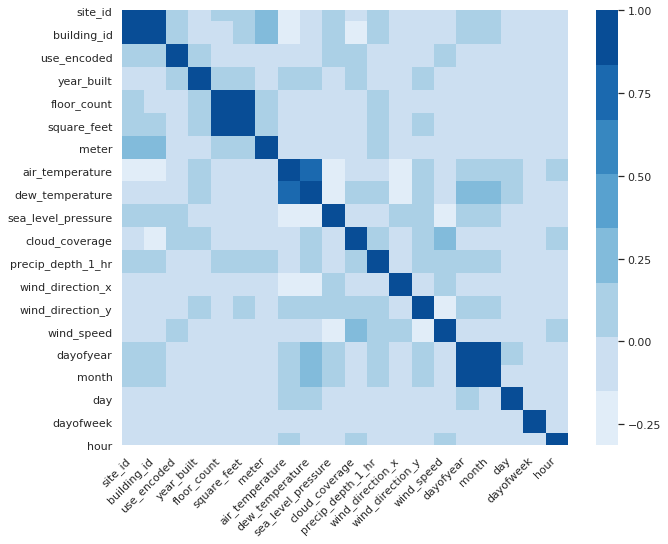

In [32]:
fig = plt.figure(figsize=(10, 8))
sns.heatmap(pearson, cmap=sns.color_palette('Blues', 8))
plt.xticks(rotation=45, ha='right')

In [33]:
corr = udf.correlated_feats(pearson, threshold=0.7)
corr

[('site_id', 'building_id', 0.9808612793455758),
 ('floor_count', 'square_feet', 0.9013205573669524),
 ('air_temperature', 'dew_temperature', 0.7514988326447333),
 ('dayofyear', 'month', 0.9964867635352562)]

There are 4 pairs of highly correlated features in the data:
- `site_id` and `building_id` - both of these features are actually non-cardinal categorical variables encoded as integers, so the correlation coefficient isn't reliable here
    - There is some relationship between `site_id` and `building_id` but the ordered integer encoding makes the relationship appear stronger than it actually is
    - These 2 variables are providing different information
    - Since `site_id` can be inferred from building and weather information, it wouldn't be necessary to keep it so `site_id` will be removed
- `floor_count` and `square_feet` - the majority of `floor_count` values were originally missing and filled based on the `square_feet` in a linear manner so this high correlation isn't completely reliable either
    - Before the missing values were filled, there were a lot of outliers that prevented it from being a strong correlation
    - Since they were filled in such a way that increased the correlation, only 1 is really needed here
    - `floor_count` will be removed because `square_feet` is a more accurate description of a building's size
- `air_temperature` and `dew_temperature` - as seen in the visualizations during the EDA process, these 2 features do track each other quite closely so only 1 is necessary
    - `dew_temperature` will be dropped as `air_temperature` is a more concrete measure of the weather
- `dayofyear` and `month` - both of these features were extracted from the `timestamp` along the timeline of the year so it makes sense that there is a strong correlation
    - These 2 features actually do provide similar information so it would be redundant to keep both
    - `month` will be dropped as `day_of_year` is more fine-grained and may provide more information

    
##### Create a list of columns to drop and add the `site_id`, `floor_count`, `month`, and `dew_temperature` columns

In [22]:
cols_to_drop = ['site_id', 'floor_count', 'month', 'dew_temperature']

In [23]:
del const, const_cat, dup, corr, pearson, fig
gc.collect()

286

<a id='seln'></a>
## 5. Feature Selection
[Back to top](#content3)